In [82]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt

In [83]:
nside = 256
mission_time_is_sec = 24*3600
instrument = "MFT"
channel = "M1-140"

In [84]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [85]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [86]:
dets=[]
detquats=[]
for detname in channelinfo.detector_names:
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = 1
    dets.append(det)
    detquats.append(det.quat)
    
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [87]:
Mbsparams = lbs.MbsParameters(make_cmb =True,
                              make_fg = False,
                              gaussian_smooth = True,
                              bandpass_int = False,
                              nside = nside,
                             )

mbs = lbs.Mbs(simulation=sim,
              parameters=Mbsparams,
              channel_list=channelinfo,
             )
maps = mbs.run_all()[0][channel]

[2021-05-18 10:11:27,234 INFO MPI#0000] generating and saving cmb simulations


***************** D
***************** D
***************** D


/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_210518.fits
  warnings.warn(f"Access data from {full_path}")


In [88]:
hwp_sys = lbs.HwpSys(sim)
hwp_sys.set_parameters(maps=maps,
                       integrate_in_band=False,
                       correct_in_solver=False,
                       built_map_on_the_fly=False,
                       nside=nside,
                      )

In [89]:
hwp_sys.fill_tod(obs,pointings,hwp_radpsec)

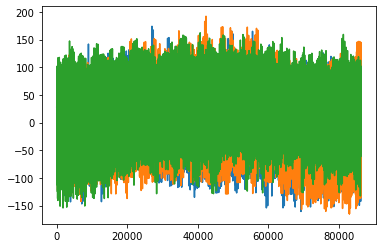

In [90]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])
plt.plot(obs.tod[2])

In [91]:
m = lbs.make_bin_map([obs],nside).T

/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationW

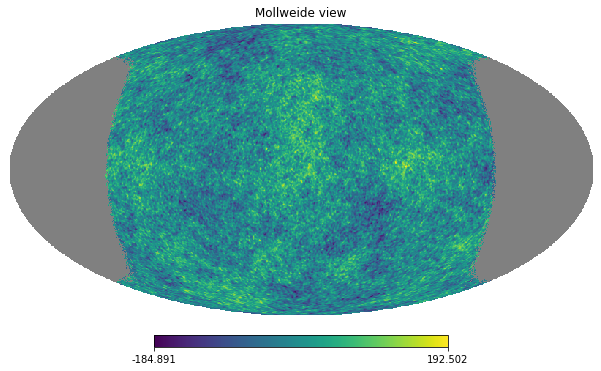

In [92]:
hp.mollview(m[0])

In [93]:
hp.mollview?